In [2]:
from warnings import simplefilter
# ignore all future warnings / convergence warnings, !!! In a real workflow do not do this !!!
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
import descarteslabs as dl
import numpy as np
import pickle
from descarteslabs.client.services import Places
import pandas as pd
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import descarteslabs.workflows as wf
import shapely.geometry
import shapely.ops
import shapely.prepared
import rasterio.features
import ipyleaflet
from tqdm.notebook import tqdm
%matplotlib inline
# 65535

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/opt/conda/lib/python3.7/site-packages/ipyleaflet/leaflet.py:338: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)


In [3]:
sac = shapely.geometry.shape(
    dl.places.shape("north-america_united-states_california_sacramento-valley").geometry
)
sj = shapely.geometry.shape(
    dl.places.shape(
        "north-america_united-states_california_san-joaquin-valley"
    ).geometry
)
central_valley_aoi = sac.union(sj)

tiles = dl.scenes.DLTile.from_shape(
    central_valley_aoi, resolution=15, tilesize=512, pad=0
)
print(len(tiles))
start_datetime = "2019-01-01"
end_datetime = "2020-01-01"

1917


In [4]:
tiles[0].__geo_interface__

{'type': 'Polygon',
 'coordinates': (((-123.0902890960485, 40.240006002142316),
   (-123.0, 40.24004122038576),
   (-123.0, 40.309233215277644),
   (-123.09038116781777, 40.30919791126174),
   (-123.0902890960485, 40.240006002142316)),)}

In [5]:
def cloud_masked_daily_product(product_id: str, start_datetime: str, end_datetime: str) -> wf.ImageCollection:
    "Get a product by ID, masked by the DL cloud mask and mosaicked by day"
    if 'airbus' in product_id.lower():
        cloud = 'derived:visual_cloud_mask'
    else:
        cloud = "valid-cloudfree"
    ic = wf.ImageCollection.from_id(product_id, start_datetime, end_datetime)
    cloudmask = (
        wf.ImageCollection.from_id(
            product_id, start_datetime, end_datetime
        ).pick_bands(cloud)
        == 0
    )

    # Make an ImageCollectionGroupby object, for quicker lookups from `ic` by date (you can use it like a dict)
    ic_date_groupby = ic.groupby(dates=("year", "month", "day"))
    # For each cloudmask date, pick the corresponding image from `ic` by date, mosiac both, and mask them.
    # (Not all scenes have cloudmasks processed, so this ensures we only return scenes that do.)
    return cloudmask.groupby(dates=("year", "month", "day")).map(
        lambda ymd, mask_imgs: ic_date_groupby[ymd].mosaic().mask(mask_imgs.mosaic())
    )

def ndvi(ic: wf.ImageCollection) -> wf.ImageCollection:
    nir, red = ic.unpack_bands("nir red")
    ndvi = (nir - red) / (nir + red)
    return ndvi.rename_bands("ndvi")

def isin(ic: wf.ImageCollection, values: list) -> wf.ImageCollection:
    "Like np.isin, for Workflows"
    assert len(values) > 0
    result = False
    for value in values:
        result = result | (ic == value)
    return result

In [35]:
start_datetime = "2019-01-01"
end_datetime = "2020-01-01"
l8_daily = cloud_masked_daily_product(
    "landsat:LC08:01:T1:TOAR", start_datetime, end_datetime
).pick_bands("red green blue nir swir1")
l8_with_ndvi = l8_daily.concat_bands(ndvi(l8_daily))
ab_ic = wf.ImageCollection.from_id(
    "airbus:oneatlas:spot:v2", start_datetime=start_datetime, end_datetime=end_datetime
).pick_bands("red green blue")
ab_date_groupby = ab_ic.groupby(dates=("year", "month", "day"))
ab_daily = ab_ic.groupby(dates=("year", "month", "day")).map(
        lambda ymd, mask_imgs: ab_date_groupby[ymd].mosaic())
cdl = wf.ImageCollection.from_id(
    "usda:cdl:v1", start_datetime="2019-01-01", end_datetime="2020-01-01"
).pick_bands("class")

grains_oils_grass_beans = [1,2,3,4,5,6,10,11,12,13,21,22,23,24,25,26,27,28,29,
                        30,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,51,
                        52,53,225,226,228,230,232,234,235,236,237,238,239,240,241,254]

deli_crops = [14, 48, 49, 50, 54, 55, 57, 206, 207, 208, 209, 213, 214, 216,
            219, 221, 222, 224, 227, 229, 231, 242, 243, 244, 245, 246, 247,
            248, 249, 250]

tree_crops = [66, 67, 68, 69, 72, 74, 75, 76, 77, 204, 210, 211, 212, 215, 217,
            218,220, 223]

crops_list = deli_crops + tree_crops

is_crops = isin(cdl, crops_list)
is_crops_19 = is_crops[-1]

four_year_combo = is_crops.sum(axis="images") + is_crops_19  # double-weight 2019
four_year_binary = four_year_combo >= 2
cdl_mask = ~four_year_binary

l8_masked = l8_with_ndvi.mask(cdl_mask)

In [7]:
l8_data, l8_inf, cdl_data, cdl_mask = wf.compute([l8_with_ndvi.ndarray,
                                        l8_daily.properties,
                                        cdl.ndarray,
                                        is_crops.ndarray], tiles[1190])
print(l8_data.shape, cdl_data.shape, type(l8_inf))


Job ID: c57f2aeaffd459aaa3c3328c83a9c460360c61d736b18c5b
[######] | Steps: 1319/1319 | Stage: SUCCEEDED                                
Job ID: c57f2aeaffd459aaa3c3328c83a9c460360c61d736b18c5b
(22, 6, 512, 512) (3, 1, 512, 512) <class 'list'>


In [8]:
crops_enc = {id_: k + 1 for k, id_ in enumerate(sorted(crops_list))}
crops_dec = {crops_enc[id_]: id_ for id_ in crops_enc}

In [9]:
np.asanyarray(cdl_data[0,0]==crops_dec[1], dtype='int32')

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],
  mask=False,
  fill_value=1,
  dtype=int32)

In [11]:
cdl_mask[0,0].shape

(512, 512)

In [12]:
def get_monthly_arrays(data, info):
    years = sorted(list(set([x['group'][0] for x in info])))
    months = sorted(list(set([x['group'][1] for x in info])))
    dates_ = list(zip(np.arange(data.shape[0], dtype=int), [x['group'] for x in info]))
    date_ranges = {(x,y): [] for x in years for y in range(1,13)}
    for d in dates_:
        date_ranges[d[1][:2]].append(d[0])
    avg_array = np.zeros((12*len(years), data.shape[1], data.shape[2], data.shape[3]))
    for k, dr in enumerate(sorted([(x,y) for x in years for y in months])):
        if date_ranges[dr]:
            avg_array[k] = data[date_ranges[dr][0]:date_ranges[dr][-1]+1].mean(axis=0)
    return avg_array

In [13]:
t = get_monthly_arrays(l8_data, l8_inf)
print(t.shape)

(12, 6, 512, 512)


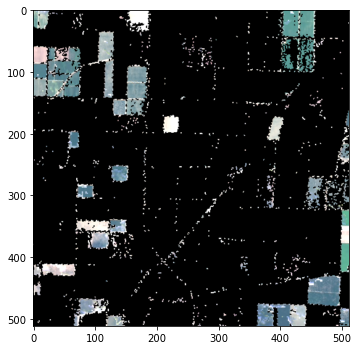

In [14]:
dl.scenes.display(t[5,:3]*np.array(cdl_mask[2,0], dtype=int), size=5)

In [15]:
central_valley_ctx = dl.scenes.AOI(central_valley_aoi, shape=(2048, 2048), crs="EPSG:4326")
all_cdl = four_year_binary.compute(central_valley_ctx)


Job ID: 88ca59a396be24e186d3f200b6059b6cad8cc20d9563bf8c
[######] | Steps: 10/10 | Stage: SUCCEEDED                                    
Job ID: 88ca59a396be24e186d3f200b6059b6cad8cc20d9563bf8c


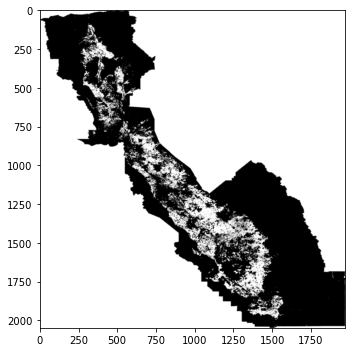

In [16]:
dl.scenes.display(all_cdl.ndarray, size=5)

In [17]:
# Workflows gives us back the geotransform for the GeoContext we used,
# which we'll need to pass on to rasterio so it can convert from pixel coordinates to lat-lon coordinates
all_cdl.geocontext["gdal_geotrans"]

(-123.06822048046871,
 0.0027648945312499992,
 0.0,
 40.45317188671874,
 0.0,
 -0.0027648945312499992)

In [18]:
# vectorize the whole raster, only keeping the shapes with a pixel value of 1 
# (i.e. pixels that meet our CDL criteria)
shapes = list(
    geom for geom, value in
    rasterio.features.shapes(
        all_cdl.ndarray.astype("uint8"), 
        transform=rasterio.transform.Affine.from_gdal(*all_cdl.geocontext["gdal_geotrans"])
    )
    if value == 1
)
print(len(shapes))
shapes[:2]

4957


[{'type': 'Polygon',
  'coordinates': [[(-121.85719667578121, 40.43934741406249),
    (-121.85719667578121, 40.43658251953124),
    (-121.85443178124996, 40.43658251953124),
    (-121.85443178124996, 40.43934741406249),
    (-121.85719667578121, 40.43934741406249)]]},
 {'type': 'Polygon',
  'coordinates': [[(-122.19451380859371, 40.38681441796874),
    (-122.19451380859371, 40.38128462890624),
    (-122.19174891406246, 40.38128462890624),
    (-122.19174891406246, 40.37851973437499),
    (-122.1889840195312, 40.37851973437499),
    (-122.1889840195312, 40.38681441796874),
    (-122.19451380859371, 40.38681441796874)]]}]

In [19]:
# union all of the individual shapes into one, and simplify a little 
# (we don't need that many points!)
all_valid = shapely.ops.unary_union([shapely.geometry.shape(s) for s in shapes]).simplify(0.3)

type(all_valid)

shapely.geometry.multipolygon.MultiPolygon

In [20]:
# now, we're going to intersect our tiles with the `all_valid` geometry. 
# It's slightly faster if we use a shapely prepared geometry.
all_valid_prepped = shapely.prepared.prep(all_valid)
valid_tiles = [t for t in tqdm(tiles) if all_valid_prepped.intersects(t.geometry)]
print(len(valid_tiles), len(valid_tiles) / len(tiles))


930 0.48513302034428796


In [21]:
tiles.index(valid_tiles[0])

80

In [22]:
tiles_to_run = valid_tiles[:10]
jobs = [wf.compute([l8_daily.ndarray, l8_daily.properties, cdl.ndarray], 
                   tile, block=False) for tile in tqdm(tiles_to_run)]
job_to_tile = {j: t for j, t in zip(jobs, tiles_to_run)}

In [23]:
from typing import Iterator, Sequence
import time

import descarteslabs.workflows as wf


def as_completed(jobs: Sequence[wf.Job], interval_sec: int = 5) -> Iterator[wf.Job]:
    """
    Iterator over Jobs that yields each Job when it completes.
    
    Parameters
    ----------
    jobs: Sequence[wf.Job]
        Jobs to wait for
    interval_sec: int, optional, default 5
        Wait at least this many seconds between polling for job updates.
        
    Yields
    ------
    job: wf.Job
        A completed job (either succeeded or failed).
    """
    jobs = list(jobs)
    while len(jobs) > 0:
        loop_start = time.perf_counter()

        i = 0
        while i < len(jobs):
            job = jobs[i]
            if not job.done:  # in case it's already loaded
                try:
                    job.refresh()
                except Exception:
                    continue  # be resilient to transient errors for now

            if job.done:
                yield job
                del jobs[i]  # "advances" i
            else:
                i += 1

        loop_duration = time.perf_counter() - loop_start
        if len(jobs) > 0 and loop_duration < interval_sec:
            time.sleep(interval_sec - loop_duration)
            

def handle_result(tile, l8_data, l8_info, cdl_data):
    print(tile.key, l8_data.shape, get_monthly_arrays(l8_data, l8_info).shape)
    # TODO: do whatever you'd do with the result!

In [36]:
failed = []
tile_fp = 'data/tile_arrays_raw/'
cdl_fp = 'data/tile_cdl_raw/'
prop_fp = 'data/tile_props/'
tile_no = 0
tile_imgs = []
tile_infs = []
cdl_infs = []
for k in tqdm(range(10)):
    tiles_to_run = [valid_tiles[k]]
    jobs = [wf.compute([l8_daily.ndarray, l8_daily.properties, cdl.ndarray], 
                       tile, block=False) for tile in tiles_to_run]
    job_to_tile = {j: t for j, t in zip(jobs, tiles_to_run)}
    for job in as_completed(jobs):
        if job.error is not None:
            failed.append(job)
            print(job.error)
        else:
            l8_data, l8_info, cdl_data = job.result(progress_bar=False)
            tile = job_to_tile[job]
            tile_imgs.append(l8_data)
            tile_infs.append(l8_info)
            cdl_infs.append(cdl_data)
            #np.save(f"{tile_fp}tile_{tile_no}.npy", np.array(l8_data))
            #np.save(f"{cdl_fp}tile_{tile_no}.npy", np.array(cdl_data))
            #with open(f"{prop_fp}tile_{tile_no}.pickle", 'wb') as path:
            #    pickle.dump(l8_info, path, protocol=pickle.HIGHEST_PROTOCOL)
            #tile_no += 1

In [122]:
crops_enc = {id_: k + 1 for k, id_ in enumerate(sorted(crops_list))}
crops_dec = {crops_enc[id_]: id_ for id_ in crops_enc}
crops_labels = {
    75: 'Almonds',
    76: 'Walnuts',
    211: 'Olives',
    204: 'Pistachios',
    220: 'Plums',
    54: 'Tomatoes',
    214: 'Broccoli',
    48: 'Watermelons',
    50: 'Cucumbers',
    69: 'Grapes',
    212: 'Oranges',
    67: 'Peaches',
    49: 'Onions',
    74: 'Pecans',
    66: 'Cherries',
    222: 'Squash'
}

In [102]:
crops_enc[0] = 0
def process_cdl(cdl_r):
    flat = np.array(cdl_r).reshape(512*512)
    flat = pd.Series(flat).apply(lambda v: v * (int(v) in crops_enc))
    flat = flat.apply(lambda v: crops_enc[int(v)])
    return flat.values.reshape((512,512))

def get_rf_data(img, crop):
    crop = process_cdl(crop)
    nz = np.where(crop > 0)
    res_y = crop[nz]
    res_x = img[:,:,nz[0],nz[1]].reshape((60,nz[0].shape[0])).transpose((1,0))
    return res_x, res_y

In [125]:
X, y = get_rf_data(get_monthly_arrays(tile_imgs[0], tile_infs[0]), cdl_infs[0])
for k in range(1,10):
    X_c, y_c = get_rf_data(get_monthly_arrays(tile_imgs[k], tile_infs[k]), cdl_infs[k])
    X = np.concatenate((X,X_c))
    y = np.concatenate((y, y_c))
print(X.shape, y.shape)
y = [crops_labels[crops_dec[v]] for v in y]

In [126]:
pd.DataFrame(pd.Series(y).value_counts())

,0
Almonds,38926
Walnuts,14345
Olives,11219
Pistachios,7146
Plums,2332
Tomatoes,768
Broccoli,488
Watermelons,406
Cucumbers,259
Grapes,64


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [136]:
import seaborn as sns
def get_conf_matrix(y_true, y_pred, labels):
    df = pd.DataFrame(confusion_matrix(y_true, y_pred, labels))
    df.columns = [f'Predicted {lab}' for lab in labels]
    df.index = [f'True {lab}' for lab in labels]
    cmap = sns.light_palette((237, 85, 74), input="husl",as_cmap=True)
    plt.figure(figsize=(15,15))
    sns.heatmap(df,annot=True, fmt='d', cbar=0, cmap=cmap, annot_kws={"size": 20})
    plt.show()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [128]:
clf = RandomForestClassifier() # Will try default hyperparameters to start
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

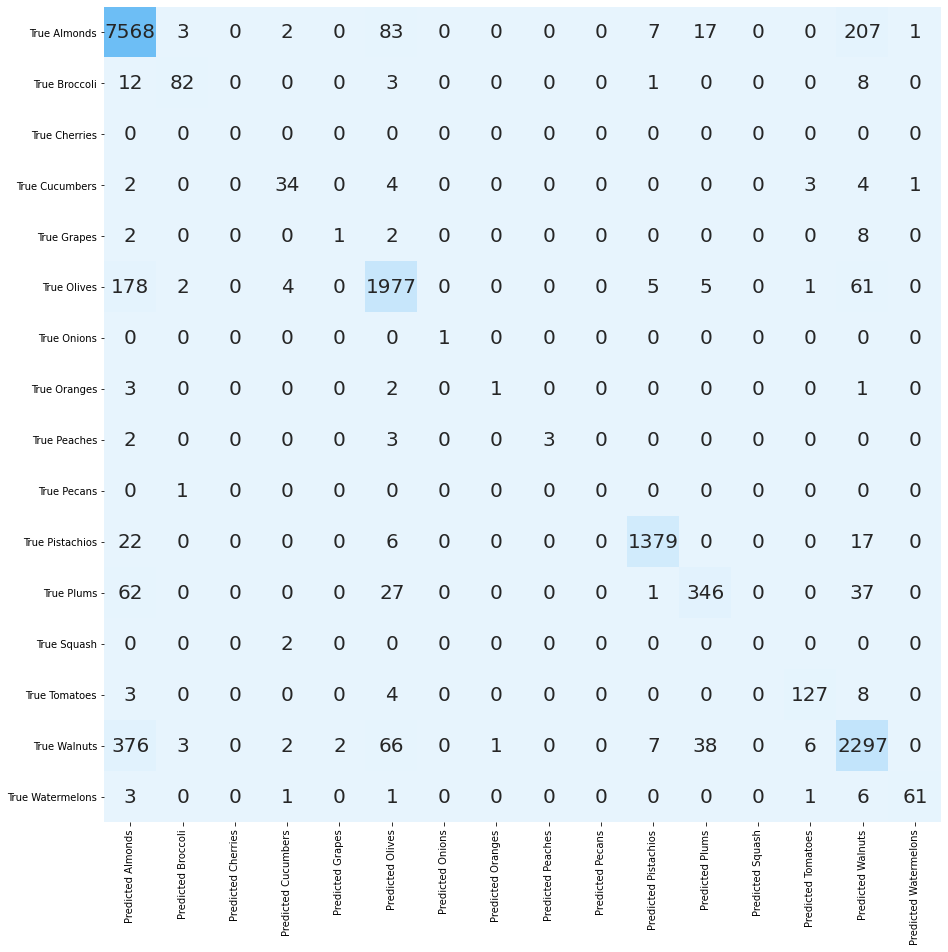

In [137]:
get_conf_matrix(y_test, clf.predict(X_test), clf.classes_)